# Imports

### Libraries

In [ ]:
# TensorFlow and tf.keras
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import sklearn

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.4.1


### GPU

In [ ]:
!nvidia-smi

Thu Jan 28 09:03:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset

In [ ]:
h5f = h5py.File('/content/drive/MyDrive/datas/chest_xray/chest_xray_10.h5', 'r')

np_images = np.array(h5f['images'])
np_labels = np.array(h5f['label'])

In [ ]:
np_images.shape

(5840, 140)

In [ ]:
np_labels.shape

(5840,)

In [ ]:
type(np_images)

numpy.ndarray

### Constants

In [ ]:
BATCH_SIZE = 64

# Datagen creation

Get the amount of normal/pneumonia

In [ ]:
(unique, counts) = np.unique(np_labels, return_counts=True)

In [ ]:
counts

array([1575, 4265])

Retrieve only the normal images

In [ ]:
# Get "normal" entries
indices = np.where(np_labels == 0)[0]
normal_images = np_images[indices]

# Normal labels
normal_labels = np.full((normal_images.shape[0],), 0)

Retrieve only the pneumonia images

In [ ]:
# Get "pneumonia" entries
indices = np.where(np_labels == 1)[0]
pneumonia_images = np_images[indices]

Get randomly 1575 pneumonia image

In [ ]:
# Get the images
random_indices = np.random.choice(pneumonia_images.shape[0], size=counts[0], replace=False)
pneumonia_images_subset = pneumonia_images[random_indices]

# Create the labels
pneumonia_labels = np.full((pneumonia_images_subset.shape[0],), 1)

Merge the subsets

In [ ]:

# Images
images = np.concatenate((normal_images, pneumonia_images_subset), axis=0)

# Labels
labels = np.concatenate((normal_labels, pneumonia_labels), axis=0)

Split train/test

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(images, labels, test_size=0.2, random_state=45, shuffle=True)
X_train = X_train / 255.
X_test = X_test / 255.

Create datagenerators

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
    
).flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

ValueError: ignored

In [ ]:
test_datagen = image.ImageDataGenerator(
    rescale=1./255
    
).flow(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [ ]:
train_iter = iter(train_datagen)
sample  = train_iter.next()

# Model

### Creation

#### Model 640

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

kernel_size = (3, 3)

def create_model_640():

  model = keras.Sequential([     
    
    keras.Input(shape=(640, 850, 1)),
    #layers.MaxPooling2D((4, 4)),
    # preprocessing.RandomCrop(256, 256),

    # Feature detection
    layers.Conv2D(8, kernel_size, padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, kernel_size, padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size, padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, kernel_size, padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),


    # Classification
    layers.Dense(128, activation='relu'), # kernel_initializer='he_uniform'
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')
  ])

    # Compile model 
  model.compile(
      loss=keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC()
        #keras.metrics.TruePositives(),
        #keras.metrics.FalsePositives(),
        #keras.metrics.TrueNegatives(),
        #keras.metrics.FalseNegatives()
      ]
  )

  return model

#### Model 64

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

kernel_size = (3, 3)

def create_model_64():
  """Max: 91%"""

  model = keras.Sequential([     
    
    keras.Input(shape=(64, 85, 1)),
    #layers.MaxPooling2D((4, 4)),
    # preprocessing.RandomCrop(256, 256),

    # Feature detection
    layers.Conv2D(64, kernel_size, padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Classification
    layers.Dense(256, activation='relu'), # kernel_initializer='he_uniform'
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
  ])

    # Compile model 
  model.compile(
      loss=keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
      metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC()
        #keras.metrics.TruePositives(),
        #keras.metrics.FalsePositives(),
        #keras.metrics.TrueNegatives(),
        #keras.metrics.FalseNegatives()
      ]
  )

  return model

#### Model 32

In [ ]:
X_train.shape[0]

2520

In [ ]:

def create_model_flat():
  """Max: 90%"""

  model = keras.Sequential([     
    
    keras.Input(shape=(140)),

    # Classification
    layers.Dense(16, kernel_initializer='he_uniform'),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),

    layers.Dense(10, activation='tanh'),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid')
  ])

    # Compile model 
  model.compile(
      
      loss=tf.keras.losses.Hinge(reduction="auto", name="hinge"),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),

      metrics=[
        tf.keras.metrics.BinaryAccuracy(
          name="binary_accuracy", dtype=None, threshold=0.5
        ),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC()
      ]
  )

  return model

**Hinge learn better than Binary Crossentropy**:
- By lowering the image shape, and thus decreasing the amount of input value, the model started to get worst: it couldn't learn. Hinge loss function, in this case, does a better job than Binary Crossentropy. It allowed to decrease even more the input given to the model, while keeping the same performance. (75%)

**Leaky ReLu and Tanh allow this model to exists**:
- With 140 inputs and 2 denses layers, this model has very few parameters. Relu has the disadvantage to eliminate any negative value. This is a loss of information. LRelu and Tanh helps to keep this information and allow the model to perfom on very few input. (85%)

**BatchNormalization is the new Dropout**:
- Dropout was tried but it decreased the model perfomance. With so few layers and neurons, Dropout just lower the model performance without lowering the overfitting. BatchNormalization did a way better job and help to improve the model. (90%)

In [ ]:
with tf.device('/device:GPU:0'):
  model = create_model_flat()

In [ ]:
type(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                2256      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_25 (Dense)             (None, 10)                170       
_________________________________________________________________
batch_normalization_6 (Batch (None, 10)                40        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 2,541
Trainable params: 2,489
Non-trainable params: 52
___________________________________________________

NoneType

**Possible improvements**:

- Write a custom binary actvation function

In [ ]:
steps = int(X_train.shape[0] / BATCH_SIZE)

with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train, batch_size=32, epochs=1200, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/1200
79/79 [==============================] - 2s 11ms/step - loss: 1.0009 - binary_accuracy: 0.4518 - precision_7: 0.4563 - recall_7: 0.4315 - auc_7: 0.4373 - val_loss: 1.0079 - val_binary_accuracy: 0.5079 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_auc_7: 0.5115
Epoch 2/1200
79/79 [==============================] - 0s 6ms/step - loss: 0.9781 - binary_accuracy: 0.6018 - precision_7: 0.6049 - recall_7: 0.5814 - auc_7: 0.6335 - val_loss: 1.0076 - val_binary_accuracy: 0.5079 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_auc_7: 0.5000
Epoch 3/1200
79/79 [==============================] - 1s 6ms/step - loss: 0.9350 - binary_accuracy: 0.7160 - precision_7: 0.7363 - recall_7: 0.6953 - auc_7: 0.7752 - val_loss: 1.0070 - val_binary_accuracy: 0.5079 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_auc_7: 0.7302
Epoch 4/1200
79/79 [==============================] - 0s 6ms/step - loss: 0.9179 - binary_accuracy: 0.7597 - precision_7: 0.7735 

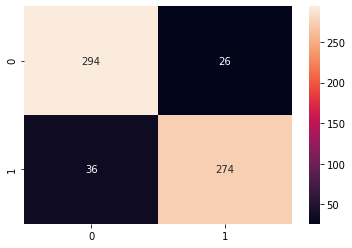

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.round(model.predict(X_test))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

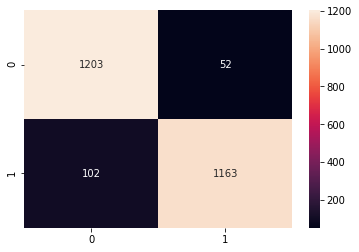

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.round(model.predict(X_train))

cf_matrix = confusion_matrix(y_train, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [ ]:
model.save('pneumonia_binary_model.h5')